In [ ]:
#Уберем предупреждния
import warnings
warnings.filterwarnings('ignore')
#Подгружаем библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#Подгружаем данные
train = pd.read_csv('train_df.csv')
test = pd.read_csv('test_df.csv')

In [ ]:
X = train.drop(['target'], axis = 1)
y = train.target

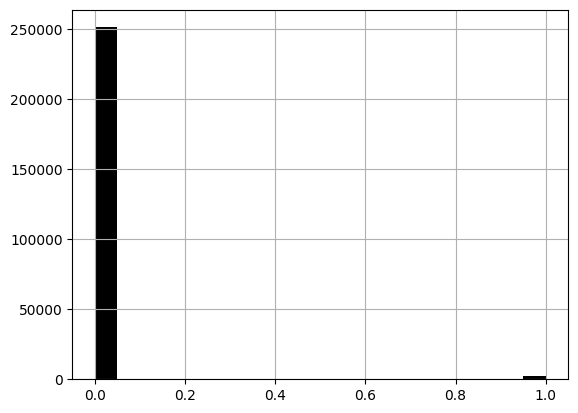

In [ ]:
train['target'].hist(bins=20, color='black');

# 2.1 Сравнение нескольких алгоритмов на сессиях
2.1.1 Выполните разбиение выборки на обучающую и отложенную.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size = 0.33, stratify = train['target'])

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve

# функция, выдающая базовые метрики классификации
def quality_report(prediction, actual):
    print("Accuracy: {:.3f}\nPrecision: {:.3f}\nRecall: {:.3f}\nf1_score: {:.3f}".format(
        accuracy_score(prediction, actual),
        precision_score(prediction, actual),
        recall_score(prediction, actual),
        f1_score(prediction, actual)
    ))

# функция для отрисовки roc-кривой и подсчёта
def plot_roc_curve(prob_prediction, actual):
    fpr, tpr, thresholds = roc_curve(actual, prob_prediction)
    auc_score = roc_auc_score(actual, prob_prediction)

    plt.plot(fpr, tpr, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC: {:.3f}'.format(auc_score))
    plt.show()

In [ ]:
#обучаем модели к-ближайших соседей
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [ ]:
knn_predict = knn.predict(X_validate)
knn_predict_proba = knn.predict_proba(X_validate)

In [ ]:
quality_report(knn_predict, y_validate)

Accuracy: 0.990
Precision: 0.222
Recall: 0.411
f1_score: 0.288


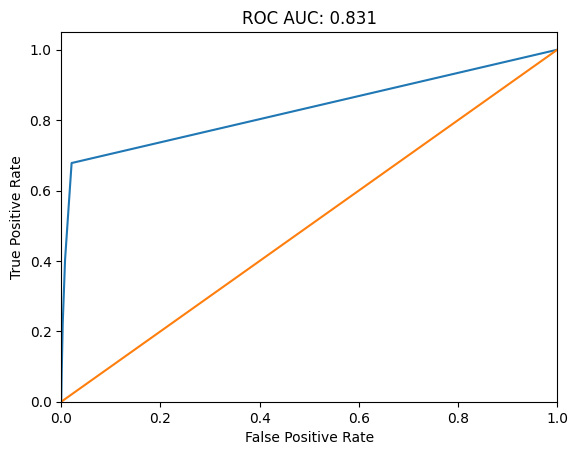

In [ ]:
plot_roc_curve(knn_predict_proba[:,1], y_validate)

У меня получилось 90%, хорошо. Попробуем другую модель

In [ ]:
#модель дерева принятия решений
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(max_depth=5, random_state=42)
dtc.fit(X_train, y_train)
dtc_predict = dtc.predict(X_validate)

In [ ]:
quality_report(dtc_predict, y_validate)

Accuracy: 0.991
Precision: 0.148
Recall: 0.593
f1_score: 0.237


In [ ]:
dtc_predict_proba = dtc.predict_proba(X_validate)

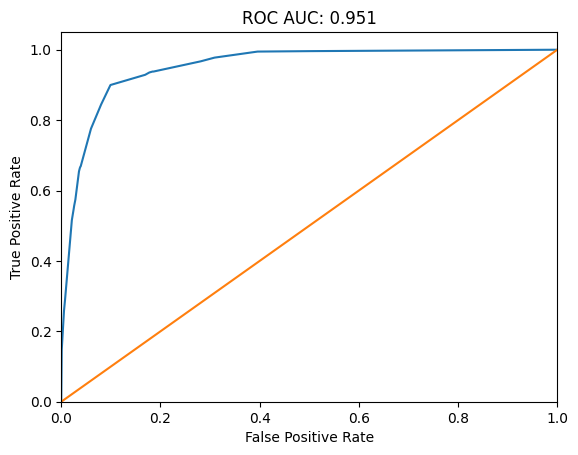

In [ ]:
plot_roc_curve(dtc_predict_proba[:,1], y_validate)

Модель получилась немного лучше, теперь сделаем голосование среди 3 моделей

In [ ]:
#ансамбль, модель случайного леса
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100, max_depth=5, n_jobs=-1)
rfc.fit(X_train, y_train)
rfc_predict = rfc.predict(X_validate)

In [ ]:
quality_report(rfc_predict, y_validate)

Accuracy: 0.991
Precision: 0.000
Recall: 0.000
f1_score: 0.000


In [ ]:
rfc_predict_proba = rfc.predict_proba(X_validate)

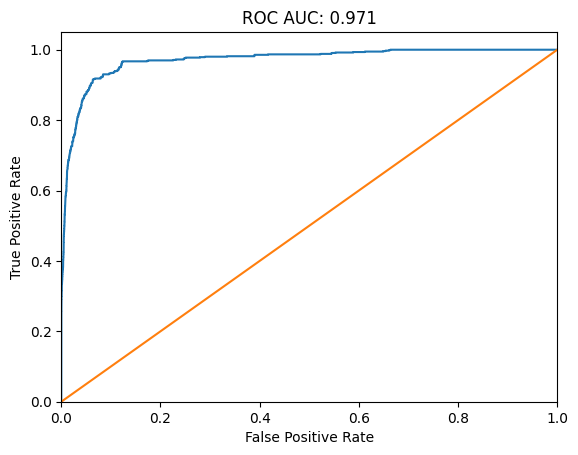

In [ ]:
plot_roc_curve(rfc_predict_proba[:,1], y_validate)

Теперь сделаем голосование

In [ ]:
#Модель голосования 3 прошлых моделек, которую сразу и обучим
from sklearn.ensemble import VotingClassifier
vtc = VotingClassifier(estimators=[('knn',knn), ('dtc', dtc), ('rfc', rfc)], voting = 'soft')
vtc.fit(X_train, y_train)

VotingClassifier(estimators=[('knn', KNeighborsClassifier()),
                             ('dtc',
                              DecisionTreeClassifier(max_depth=5,
                                                     random_state=42)),
                             ('rfc',
                              RandomForestClassifier(max_depth=5, n_jobs=-1))],
                 voting='soft')

In [ ]:
vtc_predict = vtc.predict(X_validate)

In [ ]:
quality_report(vtc_predict, y_validate)

Accuracy: 0.991
Precision: 0.050
Recall: 0.717
f1_score: 0.094


In [ ]:
vtc_predict_proba = vtc.predict_proba(X_validate)

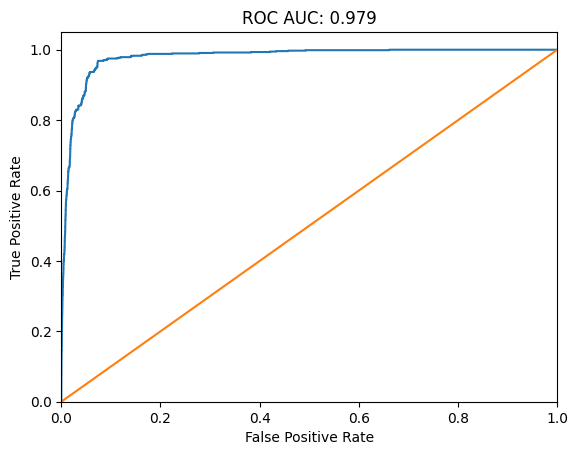

In [ ]:
plot_roc_curve(vtc_predict_proba[:,1], y_validate)

# 2.2 Гиперпараметрическая оптимизация модели

Оптимизируем модель под решаемую задачу, настраивая гиперпараметры. Построим для данной модели кривую валидации  и кривую обучения

In [ ]:
#Выберем гиперпараметры для VotingClassifier чтобы подтюнить наши параметры и вывести рещультат лучше чем был
parameters = {'voting':('soft','hard'), 'flatten_transform':(True, False),
              'weights':([2,1,1],[1,2,1],[1,1,2],[1,1,1],[3,2,1],[3,1,2],[2,3,1],[1,3,2],[1,2,3],[2,1,3])}

In [ ]:
#Подключаем гиперпараметрическую оптимизацию и ее обучаем
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(vtc, parameters)
grid.fit(X_train,y_train)

In [ ]:
quality_report(grid.predict(X_validate), y_validate)

In [ ]:
plot_roc_curve(grid.predict_proba(X_validate)[:,1], y_validate)

Точность модели получилась , модель практически не ошибается